In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no26.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no979.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no598.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no141.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no715.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no122.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no457.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no895.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no446.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no395.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no89.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no632.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no420.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no634.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no1142.jpg
/kaggle/input/brain-mri-yesno-1000img/dataset2/no/no473.jpg
/kaggle/input/brain-mri-yesno-1000img/dat

In [2]:
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

# === CONFIG ===
DATASET_DIR = "/kaggle/input/brain-mri-yesno-1000img/dataset2"  # Folder with 'yes' and 'no' subfolders
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
SEED = 42

# === Load the dataset ===
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,  # Load all images as individual tensors
    shuffle=True,
    seed=SEED
)

# === Extract images and scalar labels ===
images = []
labels = []

for img, label in dataset:
    images.append(img.numpy())
    labels.append(label.numpy().item())  # ✅ scalar (float), not array

# === Convert to numpy arrays ===
images = np.array(images)
labels = np.array(labels)

# === Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# ✅ Ensure arrays for preprocessing and training
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# ✅ Check validation class balance
unique, counts = np.unique(y_val, return_counts=True)
print("Validation set class distribution:", dict(zip(unique, counts)))

# === Preprocessing: match app.py normalization ([-1, 1]) ===
X_train = (X_train / 127.5) - 1.0
X_val = (X_val / 127.5) - 1.0

# === Create tf.data.Dataset objects ===
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Compute class weights ===
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

# === Define the model (MobileNetV2) ===
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze feature extractor

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# === Train the model ===
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, class_weight=class_weights)

# === Predict on validation set ===
y_val_pred_probs = model.predict(X_val).ravel()

# === Find best threshold using F1-score ===
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, y_val_pred_probs > t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
print(f"[INFO] Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")

# === Final predictions using best threshold ===
y_pred_final = (y_val_pred_probs > best_threshold).astype(int)

# === Evaluation metrics ===
accuracy = accuracy_score(y_val, y_pred_final)
precision = precision_score(y_val, y_pred_final)
recall = recall_score(y_val, y_pred_final)
conf_matrix = confusion_matrix(y_val, y_pred_final)

print("\n[MODEL EVALUATION ON VALIDATION SET]")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {best_f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

# === Save model as H5 ===
model.save("brain_tumor_classifier.h5")

# === Convert to TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("brain_tumor_classifier.tflite", "wb") as f:
    f.write(tflite_model)

print("\n[INFO] Model saved and converted to brain_tumor_classifier.tflite")


2025-07-17 11:26:42.087306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752751602.315091      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752751602.379550      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 3000 files belonging to 2 classes.


2025-07-17 11:26:57.265706: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Validation set class distribution: {0.0: 300, 1.0: 300}
Class weights: {0: 1.0, 1: 1.0}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 74s 852ms/step - accuracy: 0.6807 - loss: 0.6076 - val_accuracy: 0.9317 - val_loss: 0.2241
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 792ms/step - accuracy: 0.9151 - loss: 0.2278 - val_accuracy: 0.9433 - val_loss: 0.1566
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 800ms/step - accuracy: 0.9440 - loss: 0.1545 - val_accuracy: 0.9500 - val_loss: 0.1299
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 817ms/step - accuracy: 0.9623 - loss: 0.1192 - val_accuracy: 0.9633 - val_loss: 0.1158
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 815ms/step - accuracy: 0.9606 - loss: 0.1093 - val_accuracy: 0.9633 - val_loss: 0.1242
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 810ms/step - accuracy: 0.9601 - loss: 0.0979 - val_accuracy: 0.9683 - val_loss: 0.1000
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 806ms/step - accuracy: 0.9684 - loss: 0.0811 - val_accuracy: 0.9667 - val_loss: 0.0906
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 818ms/step - accuracy: 0.9762 - loss: 0.0710 - val_accu

W0000 00:00:1752752353.782476      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752752353.782555      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1752752353.966157      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


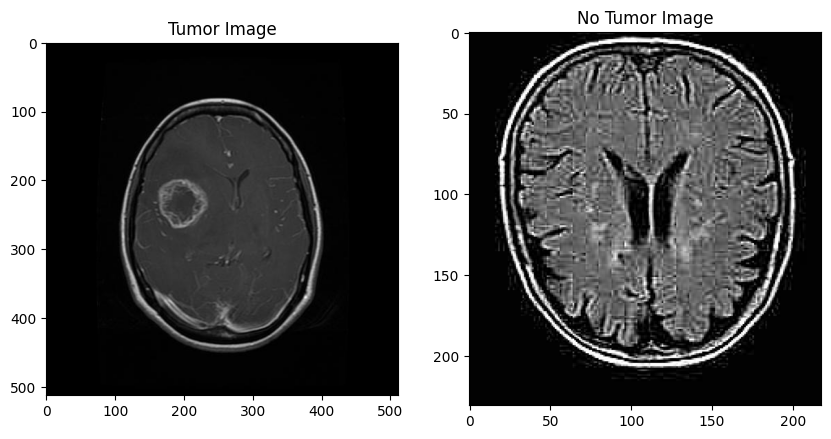

In [3]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, auc

def show_sample_images(tumor_path, no_tumor_path):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(Image.open(os.path.join(tumor_path, random.choice(os.listdir(tumor_path)))))
    axs[0].set_title("Tumor Image")
    axs[1].imshow(Image.open(os.path.join(no_tumor_path, random.choice(os.listdir(no_tumor_path)))))
    axs[1].set_title("No Tumor Image")
    plt.show()

show_sample_images('/kaggle/input/brain-mri-yesno-1000img/dataset2/yes','/kaggle/input/brain-mri-yesno-1000img/dataset2/no')

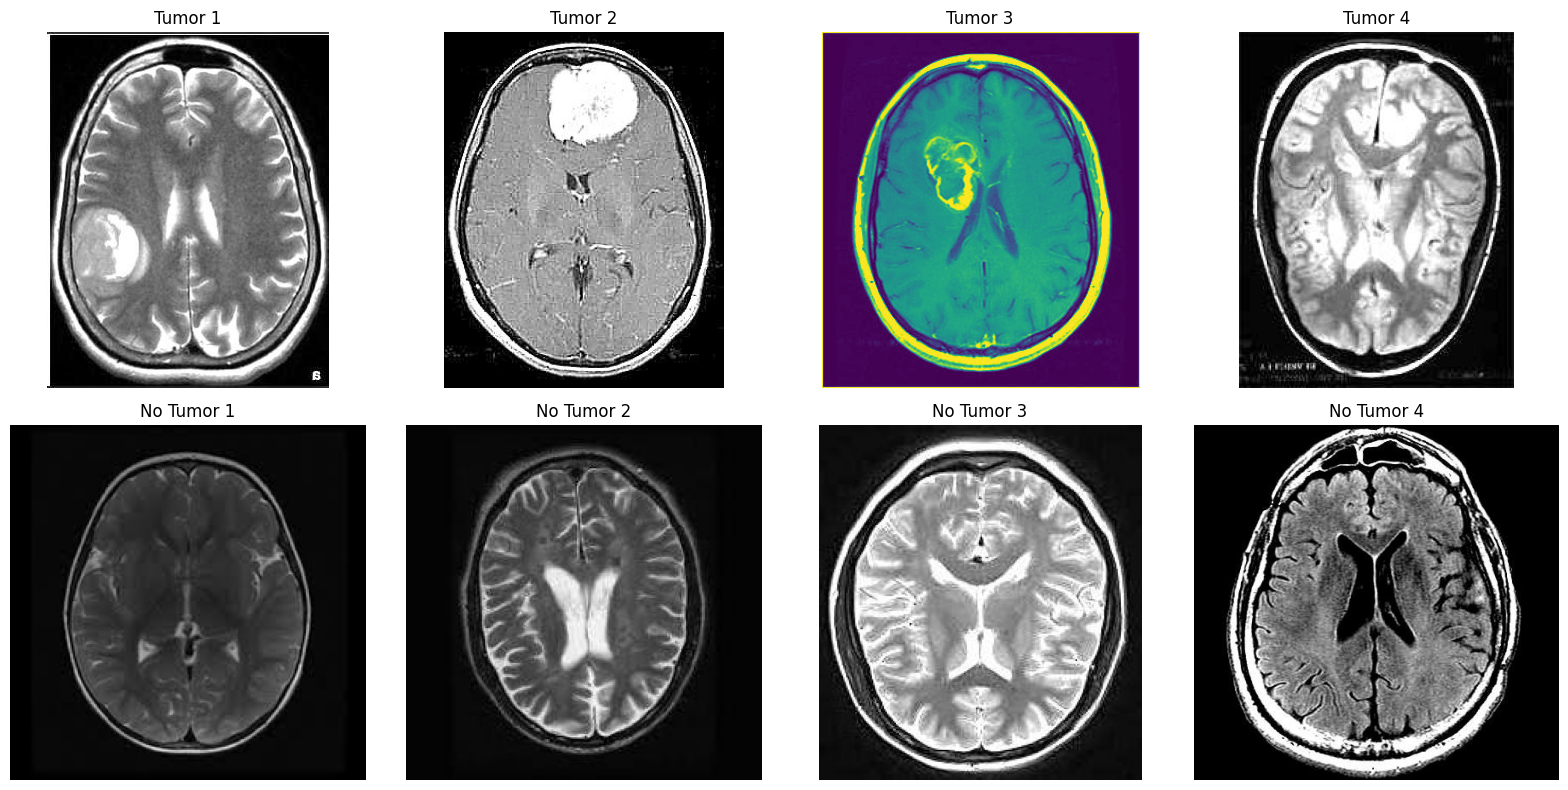

In [4]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_sample_images(tumor_path, no_tumor_path, num_images=4):
    fig, axs = plt.subplots(2, num_images, figsize=(4*num_images, 8))

    tumor_images = random.sample(os.listdir(tumor_path), num_images)
    no_tumor_images = random.sample(os.listdir(no_tumor_path), num_images)

    for i in range(num_images):
        # Tumor images (top row)
        img_tumor = Image.open(os.path.join(tumor_path, tumor_images[i]))
        axs[0, i].imshow(img_tumor)
        axs[0, i].set_title(f"Tumor {i+1}")
        axs[0, i].axis('off')

        # No Tumor images (bottom row)
        img_no_tumor = Image.open(os.path.join(no_tumor_path, no_tumor_images[i]))
        axs[1, i].imshow(img_no_tumor)
        axs[1, i].set_title(f"No Tumor {i+1}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_sample_images(
    '/kaggle/input/brain-mri-yesno-1000img/dataset2/yes',
    '/kaggle/input/brain-mri-yesno-1000img/dataset2/no',
    num_images=4
)


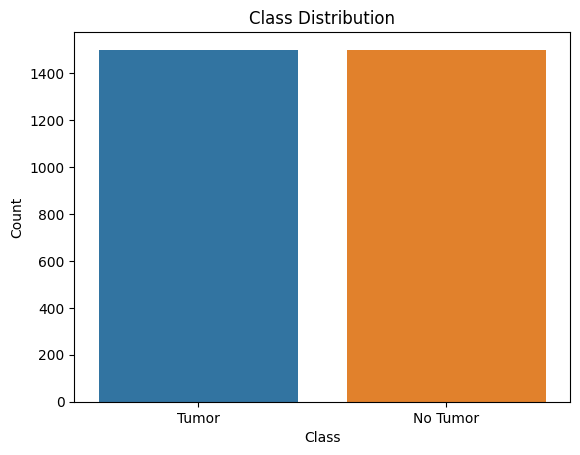

In [5]:


# ========== 2. Plot Class Distribution ==========
def plot_class_distribution(tumor_path, no_tumor_path):
    data = {'Class': ['Tumor', 'No Tumor'],
            'Count': [len(os.listdir(tumor_path)), len(os.listdir(no_tumor_path))]}
    df = pd.DataFrame(data)
    sns.barplot(x='Class', y='Count', data=df)
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(
    '/kaggle/input/brain-mri-yesno-1000img/dataset2/yes',
    '/kaggle/input/brain-mri-yesno-1000img/dataset2/no')

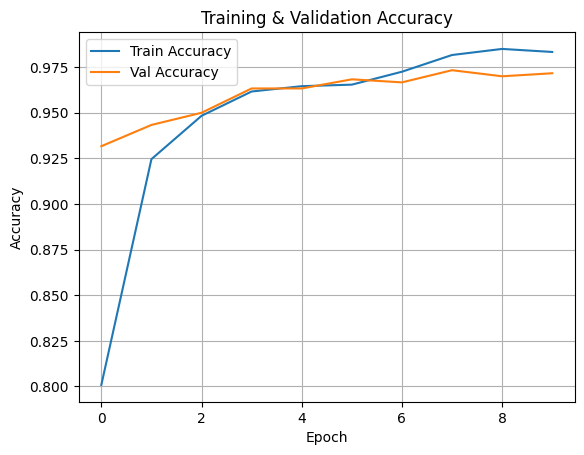

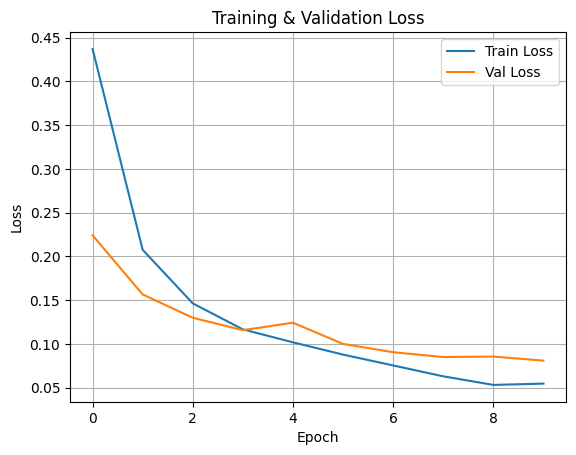

In [6]:
def plot_training_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

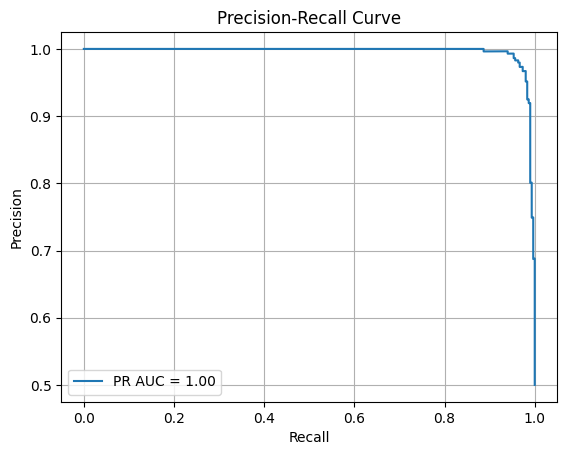

In [7]:
def plot_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label=f'PR AUC = {auc(recall, precision):.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall(y_val, y_val_pred_probs)

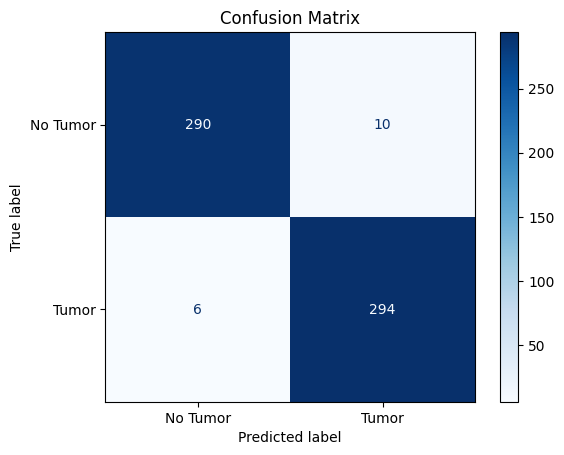

In [8]:
# ========== 5. Confusion Matrix ==========
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No Tumor", "Tumor"]).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

show_confusion_matrix(y_val, y_pred_final)

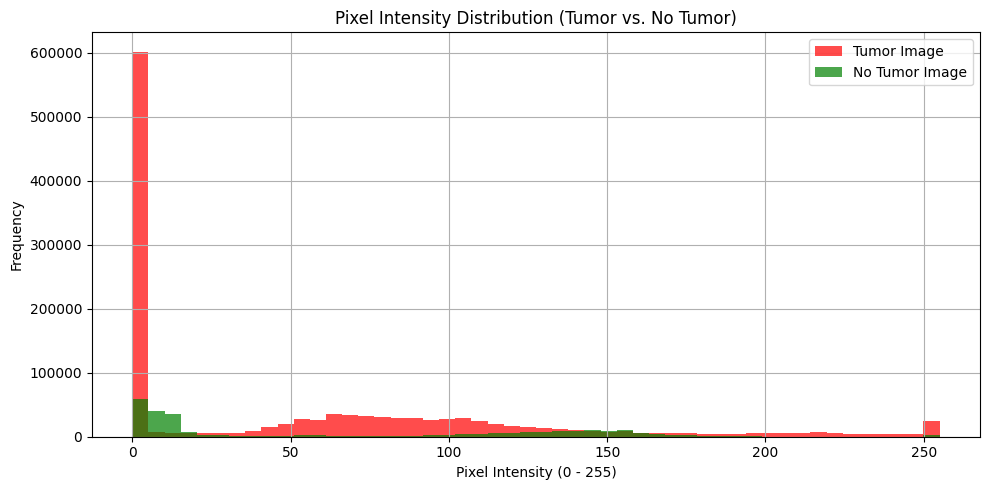

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Set paths
tumor_path = '/kaggle/input/brain-mri-yesno-1000img/dataset2/yes'
no_tumor_path = '/kaggle/input/brain-mri-yesno-1000img/dataset2/no'

# Load one random image from each class
tumor_img = Image.open(os.path.join(tumor_path, random.choice(os.listdir(tumor_path)))).convert('L')  # grayscale
no_tumor_img = Image.open(os.path.join(no_tumor_path, random.choice(os.listdir(no_tumor_path)))).convert('L')

# Convert to arrays
tumor_array = np.array(tumor_img).flatten()
no_tumor_array = np.array(no_tumor_img).flatten()

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(tumor_array, bins=50, alpha=0.7, label='Tumor Image', color='red')
plt.hist(no_tumor_array, bins=50, alpha=0.7, label='No Tumor Image', color='green')
plt.title('Pixel Intensity Distribution (Tumor vs. No Tumor)')
plt.xlabel('Pixel Intensity (0 - 255)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


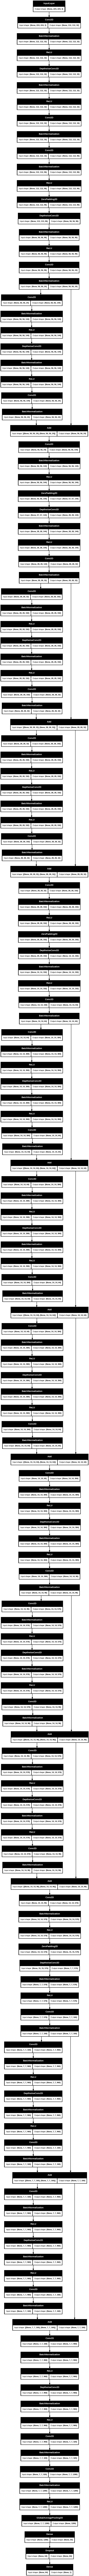

In [10]:

tf.keras.utils.plot_model(model, show_shapes=True)


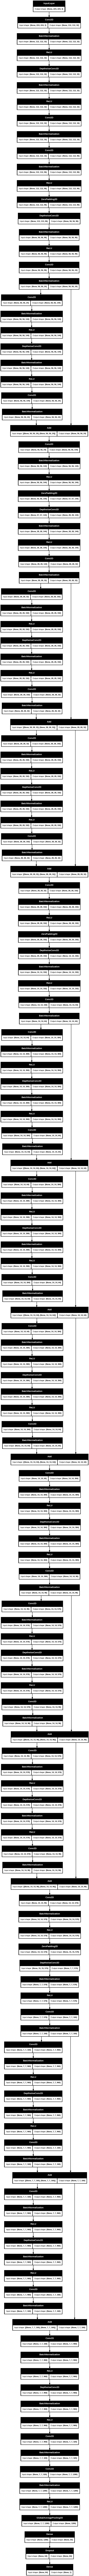

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='mobilenetv2_model.png')


In [12]:
from tensorflow.keras.models import Model
import pandas as pd

def get_condensed_model_summary(model, max_layers=20):
    summary_data = []
    for i, layer in enumerate(model.layers[:max_layers]):
        layer_name = layer.name
        layer_type = layer.__class__.__name__
        output_shape = layer.output_shape if hasattr(layer, 'output_shape') else 'N/A'
        params = layer.count_params()
        summary_data.append([layer_name, layer_type, output_shape, params])

    total_params = model.count_params()
    summary_data.append(["...", "...", "...", "..."])
    summary_data.append(["Total", "-", "-", total_params])

    df = pd.DataFrame(summary_data, columns=["Layer Name", "Layer Type", "Output Shape", "Params"])
    return df

# Example usage
condensed_df = get_condensed_model_summary(model)
print(condensed_df.to_markdown())


|    | Layer Name                   | Layer Type         | Output Shape   | Params   |
|---:|:-----------------------------|:-------------------|:---------------|:---------|
|  0 | input_layer                  | InputLayer         | N/A            | 0        |
|  1 | Conv1                        | Conv2D             | N/A            | 864      |
|  2 | bn_Conv1                     | BatchNormalization | N/A            | 128      |
|  3 | Conv1_relu                   | ReLU               | N/A            | 0        |
|  4 | expanded_conv_depthwise      | DepthwiseConv2D    | N/A            | 288      |
|  5 | expanded_conv_depthwise_BN   | BatchNormalization | N/A            | 128      |
|  6 | expanded_conv_depthwise_relu | ReLU               | N/A            | 0        |
|  7 | expanded_conv_project        | Conv2D             | N/A            | 512      |
|  8 | expanded_conv_project_BN     | BatchNormalization | N/A            | 64       |
|  9 | block_1_expand               | Conv2

In [13]:
model = tf.keras.models.load_model("/kaggle/working/brain_tumor_classifier.h5")

for i, layer in enumerate(model.layers):
    print(f"{i:02d}: {layer.name} — {layer.__class__.__name__}")


00: input_layer — InputLayer
01: Conv1 — Conv2D
02: bn_Conv1 — BatchNormalization
03: Conv1_relu — ReLU
04: expanded_conv_depthwise — DepthwiseConv2D
05: expanded_conv_depthwise_BN — BatchNormalization
06: expanded_conv_depthwise_relu — ReLU
07: expanded_conv_project — Conv2D
08: expanded_conv_project_BN — BatchNormalization
09: block_1_expand — Conv2D
10: block_1_expand_BN — BatchNormalization
11: block_1_expand_relu — ReLU
12: block_1_pad — ZeroPadding2D
13: block_1_depthwise — DepthwiseConv2D
14: block_1_depthwise_BN — BatchNormalization
15: block_1_depthwise_relu — ReLU
16: block_1_project — Conv2D
17: block_1_project_BN — BatchNormalization
18: block_2_expand — Conv2D
19: block_2_expand_BN — BatchNormalization
20: block_2_expand_relu — ReLU
21: block_2_depthwise — DepthwiseConv2D
22: block_2_depthwise_BN — BatchNormalization
23: block_2_depthwise_relu — ReLU
24: block_2_project — Conv2D
25: block_2_project_BN — BatchNormalization
26: block_2_add — Add
27: block_3_expand — Conv2D
2

Found 600 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


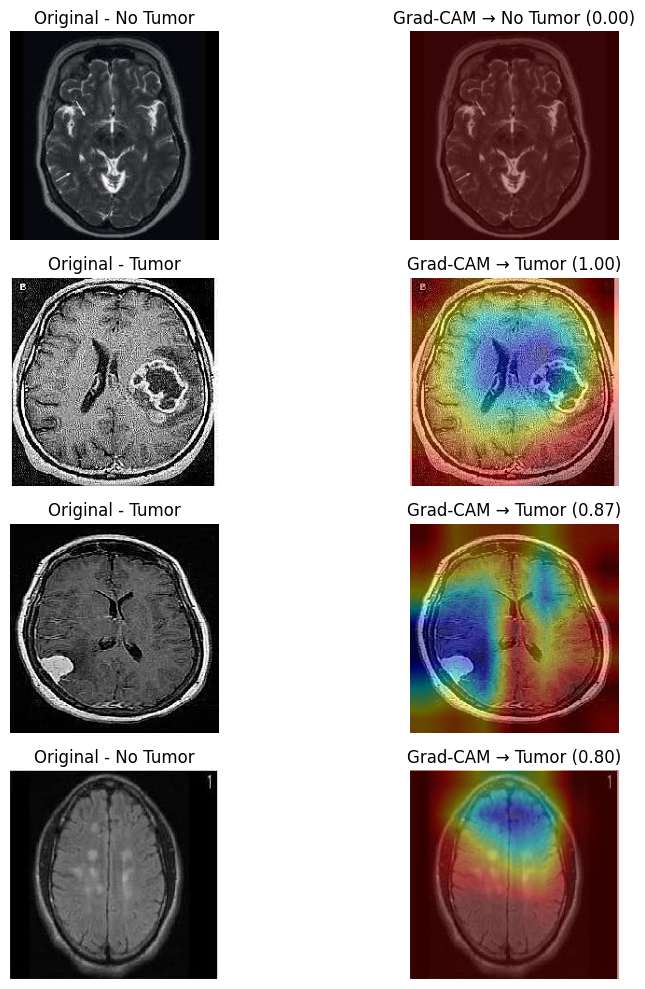

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# 1. Load trained model
model = tf.keras.models.load_model("/kaggle/working/brain_tumor_classifier.h5")
last_conv_layer_name = 'Conv_1'

# 2. Prepare validation data generator (same as training)
data_dir = '/kaggle/input/brain-mri-yesno-1000img/dataset2'  # Adjust to your dataset path

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# 3. Grad-CAM utilities
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], 
                                       [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        output = predictions[:, class_idx]

    grads = tape.gradient(output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img_array, heatmap, alpha=0.4):
    img = np.uint8(img_array * 255)  # Rescale from 0–1 to 0–255
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlaid_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlaid_img

# 4. Show 2 images each from both classes
tumor_shown, no_tumor_shown = 0, 0
max_per_class = 2

plt.figure(figsize=(10, 10))

i = 0
while tumor_shown < max_per_class or no_tumor_shown < max_per_class:
    img_batch, label_batch = next(val_generator)
    label = int(label_batch[0])
    if (label == 1 and tumor_shown < max_per_class) or (label == 0 and no_tumor_shown < max_per_class):
        img_array = img_batch[0]
        img_input = np.expand_dims(img_array, axis=0)

        # Predict and compute heatmap
        pred_prob = model.predict(img_input)[0][0]
        pred_label = "Tumor" if pred_prob >= 0.5 else "No Tumor"
        true_label = "Tumor" if label == 1 else "No Tumor"

        heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
        overlay = overlay_gradcam(img_array, heatmap)

        # Plot original and Grad-CAM
        plt.subplot(4, 2, 2 * i + 1)
        plt.imshow(img_array)
        plt.title(f"Original - {true_label}")
        plt.axis("off")

        plt.subplot(4, 2, 2 * i + 2)
        plt.imshow(overlay)
        plt.title(f"Grad-CAM → {pred_label} ({pred_prob:.2f})")
        plt.axis("off")

        if label == 1:
            tumor_shown += 1
        else:
            no_tumor_shown += 1
        i += 1

plt.tight_layout()
plt.show()
